# Домашнее задание №4 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения на Python, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений (очень полезно, чтобы писать красивый и эффективный код), а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`
- Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import collections

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, KFold

# импорт из knn.py и metrics.py
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# эти строчки позволят ноутбуку видеть изменения в knn.py и metrics.py
%load_ext autoreload
%autoreload 2

## Задание 1. KNN на датасете Fashion-MNIST

**100 баллов**

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [4]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [5]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

**Перед работой с любыми данными очень важно изучить их визуально и через описательные статистики.** 

Давайте посмотрим на какое-нибудь изображение из наших данных:

(-0.5, 27.5, 27.5, -0.5)

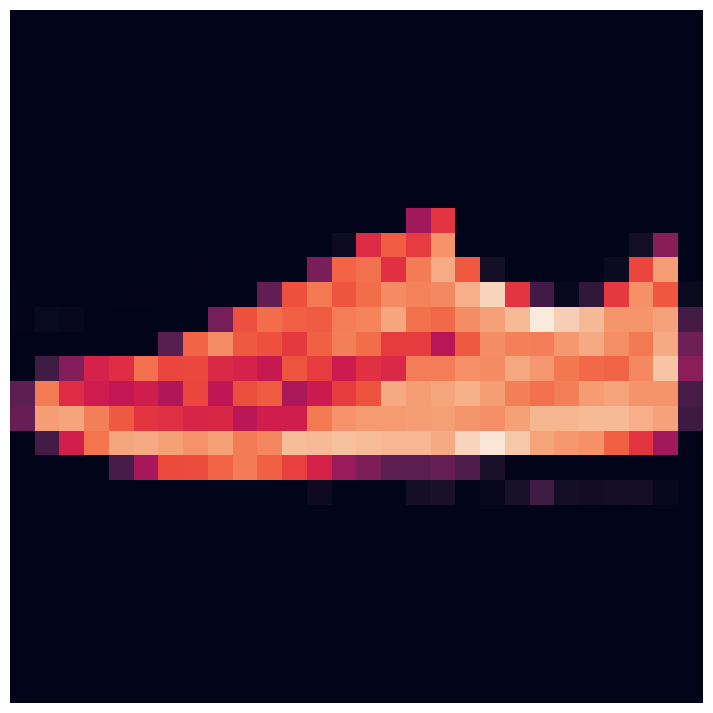

In [6]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off")

### 1.1-3. Посмотрим на все классы, сделайте небольшой EDA и разделите данные на train/test (10 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2). Не забудьте подписать название класса над каждой картинкой. 

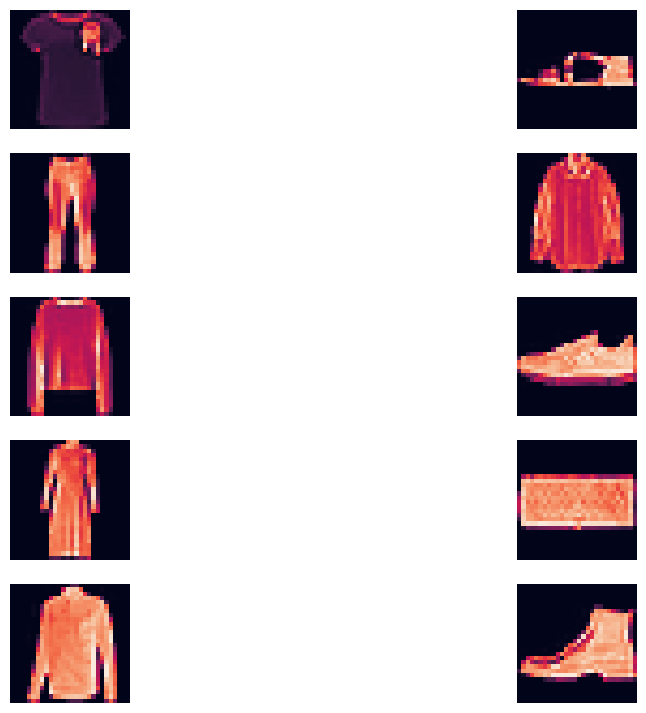

In [7]:
fig, axs = plt.subplots(5,2)
for i in range(10):
    j = 0
    while y[j] != str(i):
        j +=1
    image = X[j].reshape(28, 28, 1)
    axs[i%5, i//5].imshow(image)
    axs[i%5, i//5].axis("off")

**Первый шаг при работе с любым датасетом это EDA**. Всегда ничинайте работу с EDA (пусть даже и небольшого). Цель EDA - это узнать что-то новое о данных, понять их структуру, а также найти возможные подводные камни или эффективные решения при построении модели.

Начнем с небольшого. Посмотрите на баланс классов, один из ключевых параметров в датасетах.

In [8]:
balance = {}
for i in y:
    if i in balance.keys():
        balance[i] += 1
    else:
        balance[i] = 1
        
print(dict(sorted(balance.items())))
# болеее менее сбалансированно

# Переведем y в числа. Кажется так будет удобней
for i in range(len(y)):
    y[i] = int(y[i])

{'0': 93, '1': 102, '2': 95, '3': 121, '4': 96, '5': 98, '6': 101, '7': 79, '8': 109, '9': 106}


**Ваши выводы из EDA:**

*E.g. все классы сбалансированы или некоторые классы не сбалансированы, требуется дополнительная обработка и т.д*

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`. Совет: после разбиения всегда выводите количество объектов, попавших в каждый сплит.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


## 1.4. KNN для бинарной классификации (50 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

**Вопрос. Как сделать лучше: фильтровать данные до или после разбиения? Почему?** (5 баллов)

Ответ:

Лучше сначала отфильтровать данные, а потом разбивать датасеты. Иначе, хоть и мало вероятно, может оказать большой дисбаланс классов между датасетами.

In [10]:
X_train_0_size, X_train_1_size = 0, 0

for i in range(len(X_train)):
    if y_train[i] == 0:
        X_train_0_size += 1
    elif y_train[i] ==1:
        X_train_1_size += 1


X_test_0_size, X_test_1_size = 0, 0

for i in range(len(X_test)):
    if y_test[i] == 0:
        X_test_0_size += 1
    elif y_test[i] ==1:
        X_test_1_size += 1
    
X_train_bin = np.zeros((X_train_0_size + X_train_1_size, 784))
y_train_bin = np.zeros(X_train_0_size + X_train_1_size, dtype = 'int64')
X_test_bin = np.zeros((X_test_0_size + X_test_1_size, 784))
y_test_bin = np.zeros(X_test_0_size + X_test_1_size, dtype = 'int64')
j = 0
for i in range(len(X_train)):
    if y_train[i] == 0 or y_train[i] == 1:
        X_train_bin[j] =  X_train[i]
        y_train_bin[j] = y_train[i]
        j += 1
j = 0
for i in range(len(X_test)):
    if y_test[i] == 0 or y_test[i] == 1:
        X_test_bin[j] =  X_test[i]
        y_test_bin[j] = y_test[i]
        j += 1

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а **понимание работы алгоритма после его реализации с нуля на простом numpy**. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [11]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train_bin, y_train_bin)

### 1.4.1 Настало время писать код! (30 баллов)

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, но можно и эффективнее. 

**Примечание:** Вообще, в реальном KNN (и много где еще) используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы. По сути это такое расширение бинарного поиска на многомерное пространство. В нашем случае это не критично, но при работе с метриками расстояния на больших данных вы можете сильно выиграть в скорости, так что советую запомнить про это.

Вам нужно будет реализовать метод `compute_distances` класса `KNN` в файле `knn.py` (20 баллов).

Эта функция строит массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате она должна построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание 1:** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)), а в качестве ядра -- triangle.

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

**Обратите внимание 2:** Посмотрите на комментарии к функциям и методам в `metrics.py` и `knn.py`. Они описывают тип принимаемых аргументов и тип возврата. Написание таких комментариев и работа по ним - это важный элемент разработки кода, так что обращайте на них внимание.

Полсе написания функции, метода и вообще какого-то кода стоит провести тест и проверить, что он работает правильно.

Ниже приведен пример assert'ов, чтобы можно было проверить правильность реализации.

In [12]:
# TODO: compute_distances
dists = knn_classifier.compute_distances(X_test_bin)
assert np.isclose(dists[0, 100], np.sum(np.abs(X_test_bin[0] - X_train_bin[100])))

Проверим скорость работы реализованных методов

In [13]:
%timeit knn_classifier.compute_distances(X_test_bin)

17.1 ms ± 227 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Реализуем метод для предсказания меток класса. Обратите внимание на ожидаемый формат возврата в методе `.predict()`!

In [14]:
# TODO: predict_labels_binary in knn.py (10 баллов)
prediction = knn_classifier.predict(X_test_bin)

### 1.4.2 Метрика (15 баллов)

Теперь нужно реализовать несколько метрик для бинарной классификации.
Не забудьте подумать (и никогда не забывайте) о численной нестабильности (деление на 0).

In [15]:
# TODO: binary_classification_metrics in metrics.py (10 баллов)
my_metrics = binary_classification_metrics(prediction, y_test_bin)

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [17]:
# сравниваем со sklearn (5 баллов)
sklearn_metrics = precision_score(prediction, y_test_bin), recall_score(prediction, y_test_bin), f1_score(prediction, y_test_bin), accuracy_score(prediction, y_test_bin) 
if sklearn_metrics == my_metrics:
    print('Ok')
else:
    print('Not ok')

Ok


### Подбор оптимального k (15 баллов)

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (а лучше несколько и сравнить).

В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке. (10 баллов)

In [18]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_score = []
    test_score = []
    for i in params:
        knn_classifier = KNNClassifier(k=i)
        knn_classifier.fit(X_train, y_train)
        prediction_train = knn_classifier.predict(X_train)
        prediction_test = knn_classifier.predict(X_test)
        train_score.append(metric(prediction_train, y_train))
        test_score.append(metric(prediction_test, y_test))
            
    return train_score, test_score

In [19]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_train_bin, y_train_bin, X_test_bin, y_test_bin, params, accuracy_score)

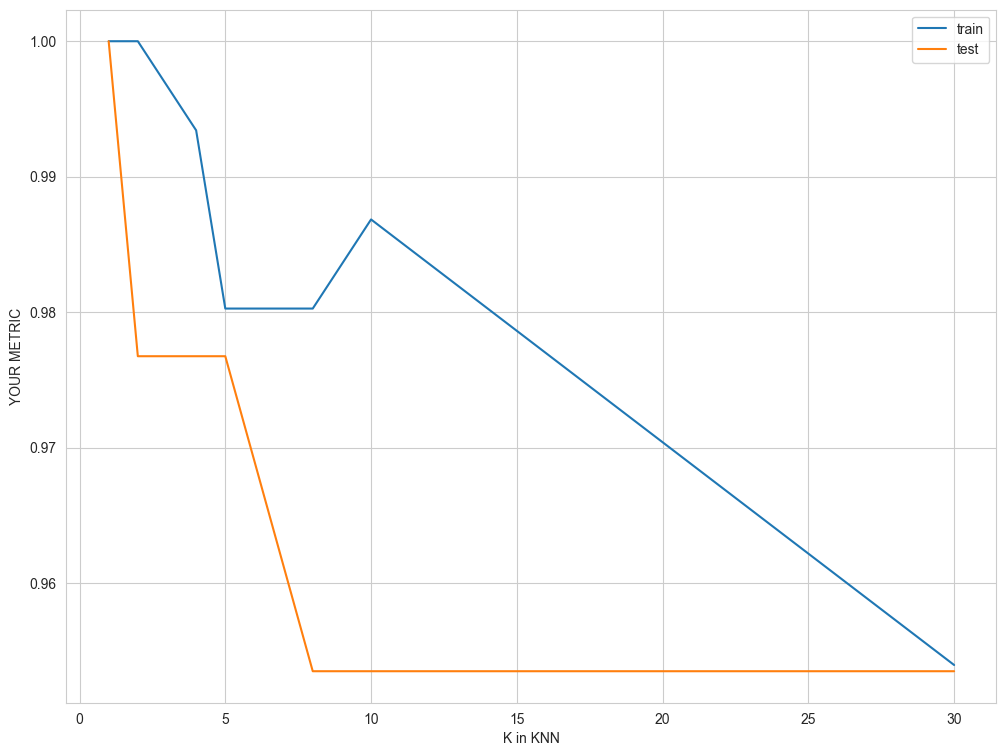

In [20]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

**Опишите результат. Какое k оптимальное и почему? (5 баллов)**

Для любых метрик `k = 2` лучший вариант (кроме `precision_score`, там бред какой-то). Но оно оптимально т.к. показывает единицу. Но это настораживает. Но пусть будет. Возможно надо делать больше выборку и делать отдельный validation датасет для проверки в таком случае.

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

In [21]:
knn_classifier = KNNClassifier(k=2)
knn_classifier.fit(X_train_bin, y_train_bin)
prediction = knn_classifier.predict(X_test_bin)
binary_classification_metrics(prediction, y_test_bin)

(0.9523809523809523, 1.0, 0.975609756097561, 0.9767441860465116)

ОЧ подозрительно.

Очень полезная практика - смотреть на несколько числовых метрик модели и на визуализации. 

Так при работе с классификацией очень полезно посмотреть на Confusion Matrix:

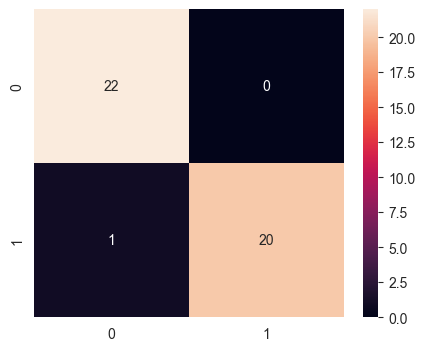

In [22]:
cf_matrix = confusion_matrix(y_test_bin, prediction)

# plot
plt.figure(figsize=(5, 4))
sns.heatmap(cf_matrix, annot=True)
plt.show()

### 1.5. Многоклассоввая классификация (5 баллов)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [23]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
prediction = knn_classifier.predict(X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [24]:
# TODO: multiclass_accuracy in metrics.py (5 баллов)
multiclass_accuracy(prediction, y_test)

0.76

### 1.6. K-fold cross validation (20 баллов)

Снова выберите оптимальное значение k. На этот раз давайте сделаем это с использованием KFoldCrossValidation. Реализуйте функцию `n_fold_cv`, которая будет разделять ваши данные на `n` частей, после чего последовательно тренировать модели на всех частях кроме одной.

В результате такого подхода у вас для каждого параметра k алгоритма k-ближайших соседей получится по n моделей. Для каждого значения параметра k отобразите боксплот с распределением метрики `multiclass_accuracy` по каждому из фолдов. Выберите лучшую модель. (20 баллов)

In [25]:
def n_fold_cv(n, X, y, k_n, metric):
    test_score = []
    skf = KFold(n_splits=5)
    for train, test in skf.split(X, y):
        knn_classifier = KNNClassifier(k=k_n)
        knn_classifier.fit(X[train], y[train])
        prediction_test = knn_classifier.predict(X[test])
        test_score.append(metric(prediction_test, y[test]))
    return test_score

/var/folders/nz/cfcy644j2w74v56vz1tr8vpm0000gn/T/ipykernel_11991/2924220632.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([k_accuracies[k] for k in params], labels=params)


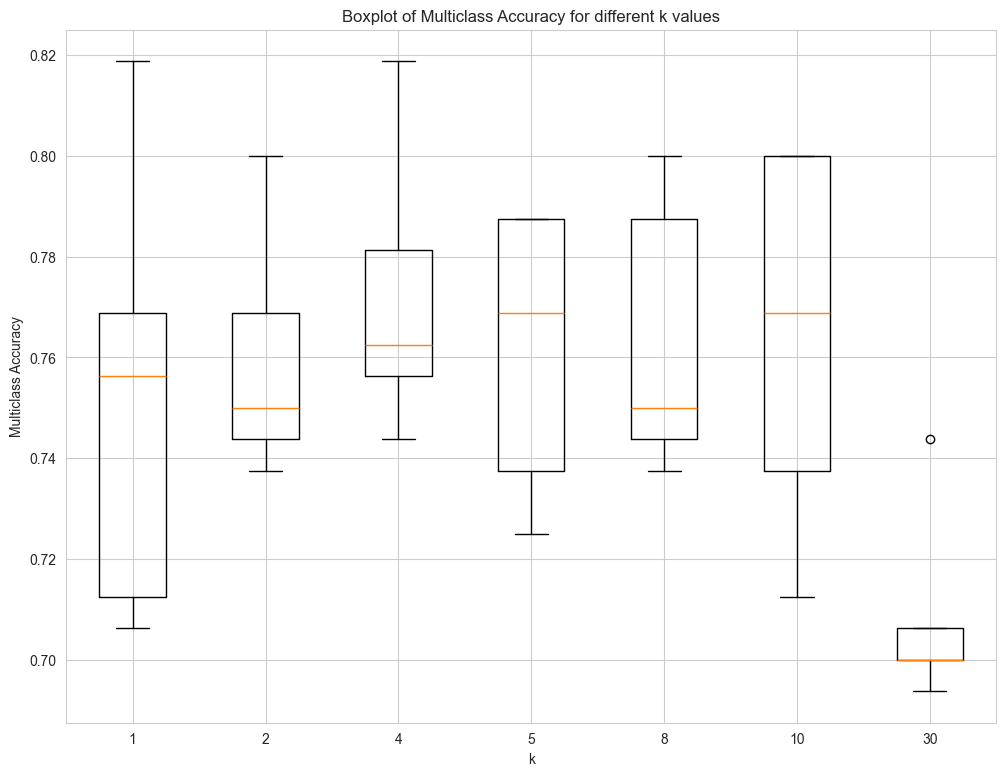

In [26]:
params = [1, 2, 4, 5, 8, 10, 30]
k_accuracies = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
for k in params:
    k_accuracies[k] = (n_fold_cv(5, X_train, y_train, k, multiclass_accuracy))

plt.boxplot([k_accuracies[k] for k in params], labels=params)
plt.xlabel('k')
plt.ylabel('Multiclass Accuracy')
plt.title('Boxplot of Multiclass Accuracy for different k values')
plt.show()

## Задание 2. KNN на датасете diabetes

**50 баллов**

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [27]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [28]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [29]:
X.sample(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
79,-0.103593,-0.044642,-0.037463,-0.026328,0.002559,0.019980,0.011824,-0.002592,-0.068332,-0.025930
148,-0.060003,0.050680,0.015350,-0.019442,0.036958,0.048164,0.019187,-0.002592,-0.030748,-0.001078
377,0.019913,0.050680,0.009961,0.018430,0.014942,0.044719,-0.061809,0.071210,0.009434,-0.063209
297,0.001751,-0.044642,-0.008362,-0.064199,-0.038720,-0.024487,0.004460,-0.039493,-0.064685,-0.054925
188,0.005383,-0.044642,-0.002973,0.049415,0.074108,0.070710,0.044958,-0.002592,-0.001496,-0.009362


### 2.1. EDA (10 обязательных баллов + 10 доп. баллов за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным и **прокомментируйте выбор стратегии**.

Вопрос: нужна ли в данном случае стандартизация и почему? 

Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test, и validate (**если не поняли это предложение, то обязательно разберитесь**).

Разбейте ваши данные на train и test.

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [30]:
from sklearn.pipeline import Pipeline

In [31]:
# Сделаем описание данных и построим гистограммы

In [32]:
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'bp'}>, <Axes: title={'center': 's1'}>,
        <Axes: title={'center': 's2'}>],
       [<Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: title={'center': 's6'}>, <Axes: >, <Axes: >]], dtype=object)

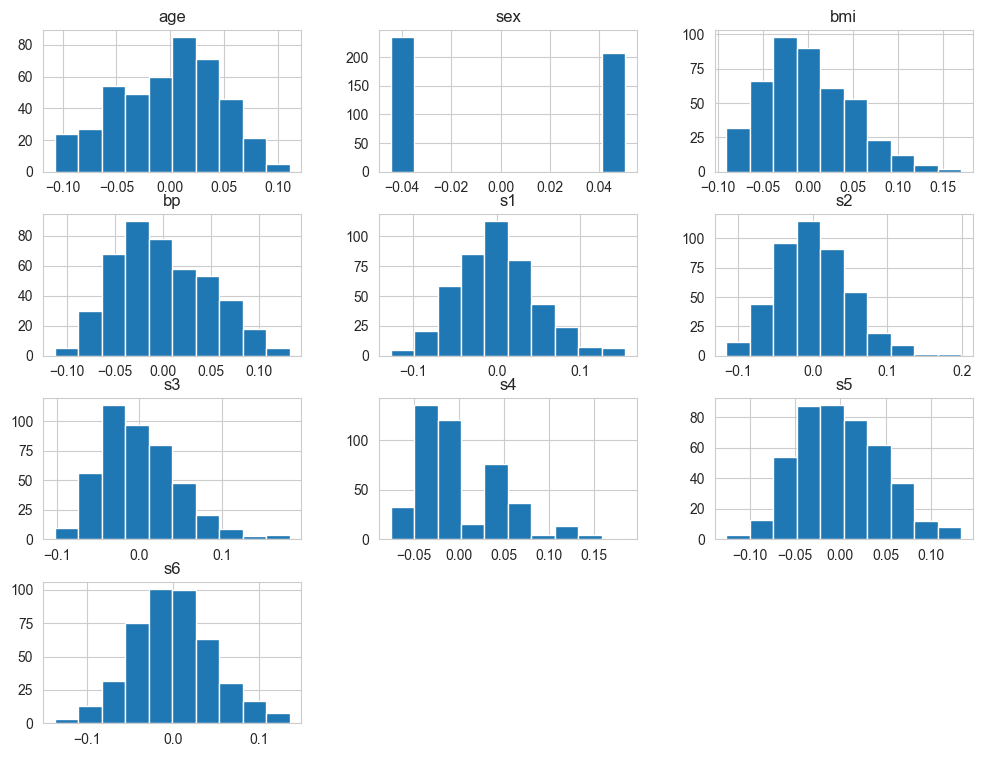

In [33]:
X.hist()

In [34]:
X.dropna(inplace = True) # нет NA

**Ваши выводы из EDA:**

Про стандартизацию: нет, она не нужна. Т.к. в описании датасета сказано: "Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times the square root of n_samples (i.e. the sum of squares of each column totals 1)."
Выбросов нет, NA нет. Ну просто сказка, а не датасет.


In [35]:
X_train, X_test = train_test_split(X, train_size=0.8)
y_train = X_train.bp
y_test = X_test.bp
X_train.drop(columns = 'bp', inplace = True)
X_test.drop(columns = 'bp', inplace = True)

### 2.2. Регрессионная модель (5 баллов)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [36]:
model = KNeighborsRegressor(n_neighbors=5, weights='uniform')
model.fit(X_train, y_train.values)
y_pred = model.predict(X_test)

### 2.3. Метрики регресии (5 баллов)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели.
Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [37]:
# TODO: r_squared, mse, mae in metrics.py
from metrics import r_squared, mse, mae

In [38]:
print(f'MSE:{mse(y_pred, y_test.values)}')
print(f'MAE:{mae(y_pred, y_test.values)}')
print(f'R2:{r_squared(y_pred, y_test.values)}')

MSE:0.0016791794382640254
MAE:0.033309235037872136
R2:0.3454492225868825


### 2.4. Подбор оптимальных гиперпараметров (20 баллов)

Мы почти дошли до конца. Теперь давайте использовать метрику MSE (можно использовать встроенную в sklearn) и с ее помощью подберем гиперпараметры для нашей модели.

Подберите оптимальные гиперпараметры для вашей модели. Просмотрите возможные варианты для метрик расстояния и ядра, а также подберите значение k. Для этого используйте класс GridSearchCV из sklearn. Обратите внимание, что GridSearchCV испольузет k-fold кросс-валидацию (параметр `cv`), а для выбора метрики используется параметр `scoring`. 

In [39]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [1, 2, 4, 5, 8, 10, 30]}]

model = KNeighborsRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, scoring = 'neg_mean_squared_error')
grid_search.fit(X_train, y_train.values)
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


**Какое получились оптимальные параметры? Для лчшей модели проведите обучение на всем тренировочном датасете и сделайте предсказания на тесте.**

В данном случае нет разницы между типами весов. По количеству соседей тоже крайне мало различий. Но пишет, что 30 это оптимальный параметр.

In [40]:
print(f'Best params:{grid_search.best_params_}')
print(f'MSE:{mse(y_pred, y_test.values)}')
print(f'MAE:{mae(y_pred, y_test.values)}')
print(f'R2:{r_squared(y_pred, y_test.values)}')

Best params:{'n_neighbors': 30, 'weights': 'uniform'}
MSE:0.0017418986326119593
MAE:0.034373810980067324
R2:0.32100103290347026


## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

